In [213]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

In [1]:
data = '/Users/zachary/JupyterLab/all-in-one/Data/hw_aa.csv'

In [215]:
df = pd.read_csv(data, sep=';')

In [216]:
df.head()

Unnamed: 0                               uid  experimentVariant version   
0           1  c4ca4238a0b923820dcc509a6f75849b                  1  v2.8.0  \
1           2  c81e728d9d4c2f636f067f89cc14862c                  0  v2.9.0   
2           3  eccbc87e4b5ce2fe28308fd9f2a7baf3                  1  v2.9.0   
3           4  a87ff679a2f3e71d9181a67b7542122c                  1  v2.8.0   
4           5  e4da3b7fbbce2345d7772b0674a318d5                  1  v2.8.0   

   purchase  
0         0  
1         0  
2         0  
3         0  
4         0

In [217]:
df.shape

(127018, 5)

In [218]:
df.purchase.unique()

array([0, 1])

In [219]:
df.groupby(by='experimentVariant')['purchase'].value_counts()

experimentVariant  purchase
0                  0           61591
                   1            1511
1                  0           60513
                   1            3403
Name: count, dtype: int64

In [220]:
# AA test

In [247]:
# Идем от общего, найдем p_value не смотря на версии приложений

a1 = df.query('experimentVariant == 0')['purchase']
a2 = df.query('experimentVariant == 1')['purchase']

stat, p_value = stats.ks_2samp(a1, a2)
print('Тест колмогорова:')
print('Статистика Колмогорова-Смирнова:', stat)
print('p-значение:', p_value)

Тест колмогорова:
Статистика Колмогорова-Смирнова: 0.029296396494409183
p-значение: 4.136200871617501e-24


In [222]:
# Проведем небольшой эксперимент с симуляцией, используя T-Test Стьюдента

In [244]:
def fp_sim_test(a1, a2):
    
    sample_size = 1000  # Размер каждой группы
    num_simulations = 1000  # Количество симуляций

    false_positives = []  # Список для хранения количества ложноположительных случаев
    for _ in range(num_simulations):

        group_1 = a1.sample(sample_size, replace=False).values
        group_2 = a2.sample(sample_size, replace=False).values

        false_positives.append(stats.ttest_ind(group_1, group_2, equal_var=False)[1])

    # Построение графика
    plt.hist(false_positives, bins = 100)
    plt.xlabel('Simulation')
    plt.ylabel('False Positives')
    plt.title('Number of False Positives in A/A Test Simulations')
    plt.show()

    # Количество ложноположительных случаев:
    print(f"FRP = {sum(np.array(false_positives) < 0.05) / num_simulations}")

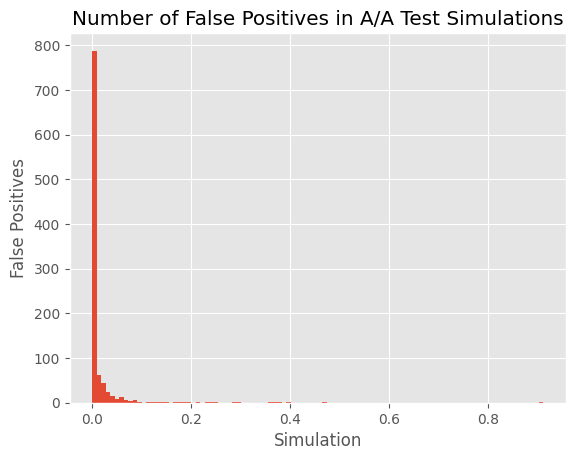

FRP = 0.936


In [245]:
fp_sim_test(a1, a2)

In [224]:
# Видим стат значимые различия в общих данных, возможно стоит разбить данные на версии

In [225]:
df_test = df.copy()

In [226]:
df_test = df_test.groupby(by=['experimentVariant', 'version']).agg({'purchase': 'sum', 'uid': 'count'})
df_test['ratio'] = np.round(df_test['purchase'] / df_test['uid'] * 100, 2)

In [227]:
# Версия 2.8.0, в зависимости от групп, значительно отличается друг от друга, возможна проблема с этой версией
df_test

purchase    uid  ratio
experimentVariant version                         
0                 v2.8.0          41  41283   0.10
                  v2.9.0         890  11921   7.47
                  v3.7.4.0       252   4204   5.99
                  v3.8.0.0       328   5694   5.76
1                 v2.8.0        1895  41552   4.56
                  v2.9.0         858  12033   7.13
                  v3.7.4.0       266   4221   6.30
                  v3.8.0.0       384   6110   6.28

In [240]:
a1_v280 = df.query("version == 'v2.8.0' & experimentVariant == 0")['purchase']
a2_v280 = df.query("version == 'v2.8.0' & experimentVariant == 1")['purchase']

In [237]:
# Убедимся, что ошибка действительно касается версии v2.8.0 и меньше альфа 0.05
_, p_value = stats.ttest_ind(a1_v280, a2_v280, equal_var = False)
print('p-значение:', p_value)

p-значение: 0.0


In [238]:
# Проведем А/А тест без использования этой версии с ошибками
df.head()

Unnamed: 0                               uid  experimentVariant version   
0           1  c4ca4238a0b923820dcc509a6f75849b                  1  v2.8.0  \
1           2  c81e728d9d4c2f636f067f89cc14862c                  0  v2.9.0   
2           3  eccbc87e4b5ce2fe28308fd9f2a7baf3                  1  v2.9.0   
3           4  a87ff679a2f3e71d9181a67b7542122c                  1  v2.8.0   
4           5  e4da3b7fbbce2345d7772b0674a318d5                  1  v2.8.0   

   purchase  
0         0  
1         0  
2         0  
3         0  
4         0

In [241]:
a1_final = df.query("version != 'v2.8.0' & experimentVariant == 0")['purchase']
a2_final = df.query("version != 'v2.8.0' & experimentVariant == 1")['purchase']

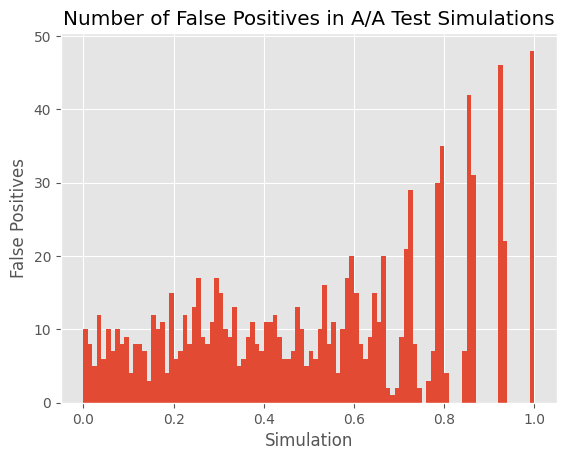

FRP = 0.041


In [246]:
fp_sim_test(a1_final, a2_final)

### Вывод:

- Первый тест Колмогорова-Смирнова без выделения версий показал, что метрика purchase имеет стат значимые различия p < 0.05
- После построения графика ложноположительных значений это подтвердилось FRP > 0.05

- Поиск проблемы показал, что есть ошибки в сплитировании данных в версии v2.8.0
- При исключении данной версии тест показал FRP < 0.05, что говорит об отсутствии стат. значимых различий